In [5]:
# imports and setup

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import linalg 


### 1.1.1

In [6]:
#Loading in the data
MNIST = pd.read_csv("MNIST_train.csv")
y = np.array(MNIST["label"])
X = np.array(MNIST.drop("label", axis=1))
MNIST_test = pd.read_csv("MNIST_test.csv")
y_test = np.array(MNIST_test["label"])
X_test = np.array(MNIST_test.drop("label", axis=1))

#Hot encode
def hotencode(y):
    Y = np.zeros((len(y), 10))
    for i in range(len(y)):
        Y[i, y[i]] = 1
    return(Y)

def loss(y, y_pred):
    return np.sum(y*(np.log1p(y) - np.log1p(y_pred)))/len(y)

def softplus(x, beta):
    return np.log(np.ones(np.shape(x)) + np.exp(beta*x))/beta


class Net:
    """ A class to represent a neural network. """

    def __init__(self, structure):
        """ Initialise the network. """
        self.structure = structure
        self.W = [np.random.randn(x, y) for x, y in zip(structure[:-1], structure[1:])]
        self.B = [np.random.randn(x, 1) for x in structure[1:]]

    def forward(self, X):
        """ Compute the forward pass. """
        for b, w in zip(self.B[:-1], self.W[:-1]):
            X = activation(w.T @ X + b)
        x = self.W[-1].T @ X + self.B[-1]
        return softmax(x)
    
    def backprop(self, X, Y):
        """ Compute the backward pass. """
        # Initialise the gradients
        dW = [np.zeros(w.shape) for w in self.W]
        dB = [np.zeros(b.shape) for b in self.B]

        # Forward pass
        A = [] # pre-activation
        H = [] # post-activation

        for b, W in zip(self.B[:-1], self.W[:-1]):
            a = W.T @ h + b if A else W.T @ X + b
            h = activation(a)
            A.append(a)
            H.append(h)

        a = self.W[-1].T @ H[-1] + self.B[-1]
        h = softmax(a)
        A.append(a)
        H.append(h)

        # Backward pass
        N = len(self.structure) -2
        for L in range(N, -1, -1):
            d = dactivation(A[L]) * (self.W[L+1] @ d) if L != N else dcost(H[L], Y) * dsoftmax(A[L])
            dB[L] = d
            dW[L] = H[L-1] @ d.T if L != 0 else X @ d.T

        return dW, dB
    
    def gradient_descent(self, batch, learning_rate):
        """ Perform gradient descent on a batch. """
        dW = [np.zeros(w.shape) for w in self.W]
        dB = [np.zeros(b.shape) for b in self.B]

        for X, Y in batch:
            dW_, dB_ = self.backprop(X, Y) # compute the gradients

            # update the gradients
            dW = [w + dw for w, dw in zip(dW, dW_)]
            dB = [b + db for b, db in zip(dB, dB_)]

        d = len(batch)
        self.W = [w - learning_rate/d * dw for w, dw in zip(self.W, dW)]
        self.B = [b - learning_rate/d * db for b, db in zip(self.B, dB)]

    def train(self, train_data, epochs = None, batch_size = None, learning_rate = None, test_data=None):
        if epochs: self.epochs = epochs
        if batch_size: self.batch_size = batch_size
        if learning_rate: self.learning_rate = learning_rate

        if test_data: n_test = len(test_data)
        n = len(train_data)

        batches = [train_data[k:k+self.batch_size] for k in range(0, n, self.batch_size)]

        for _ in tqdm(range(self.epochs)):
            for batch in batches:
                self.gradient_descent(batch, self.learning_rate)

    def predict(self, X):
        """ Predict the output for a given input. """
        return np.argmax(self.forward(X))
    
    def evaluate(self, test_data):
        """ Evaluate the network on the test data. """
        test_results = [(self.predict(x), y) for x, y in test_data]
        return sum(int(x == y) for x, y in test_results) / len(test_results)
    
def activation(x):
    """ The activation function. """
    return 1 / (1 + np.exp(-x))

def dactivation(x):
    """ The derivative of the activation function. """
    return activation(x) * (1 - activation(x))

def dcost(y, y_hat):
    """ The derivative of the cost function. """
    return y_hat - y

def softmax(x):
    """ The softmax function. """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def dsoftmax(x):
    """ The derivative of the softmax function. """
    return softmax(x) * (1 - softmax(x))

# 1.2

In [7]:
# Import the noisy data
MNIST_noisy = pd.read_csv("MNIST_train_noisy.txt", sep= " ", header=None)
y_noisy = hotencode(y)
X_noisy = np.array(MNIST_noisy)

def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar


### 1.2.1

70% of the variance is described by the first 212 values
80% of the variance is described by the first 297 values
90% of the variance is described by the first 407 values


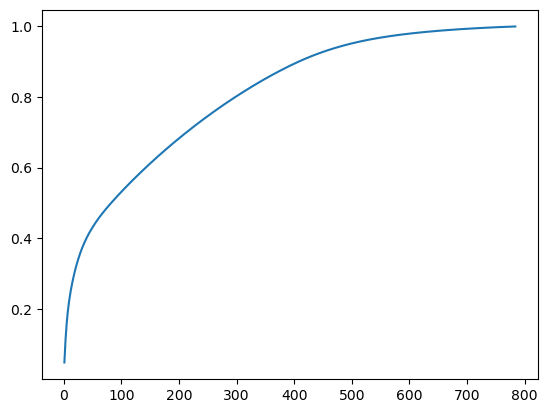

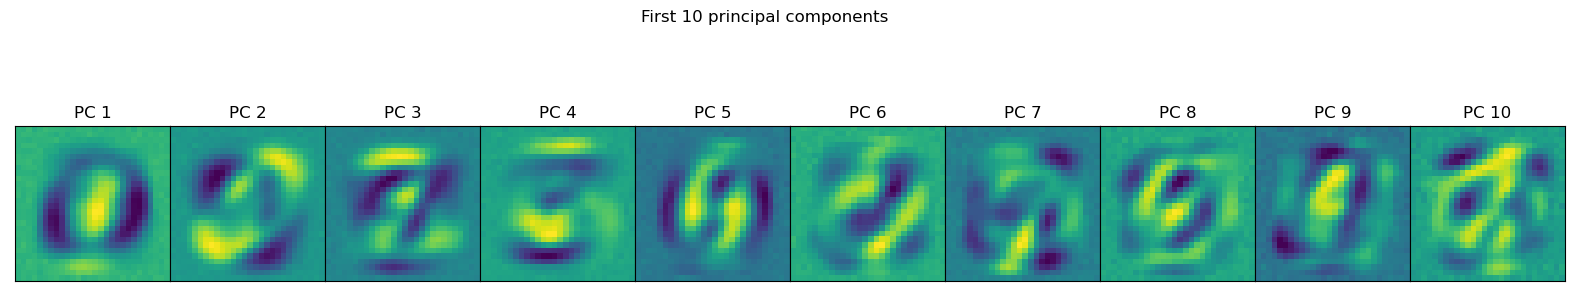

In [20]:
def PCA(X,k):
   
    X = standardise(X)

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = np.linalg.eig(C) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]
    eigenvecs = eigenvectors[:, :k]
    eigenvals = eigenvalues[:k]

    # transform our data
    X_pca = X.dot(eigenvecs) 

    return X_pca, eigenvecs, eigenvals

X_pca, eigenvectors, eigenvalues = PCA(X_noisy, 784)

total_var_list = [eigenvalues[0]]
for i in range(1, 784):
    total_var = total_var_list[-1] + eigenvalues[i] 
    total_var_list.append(total_var)
    
total_var = total_var_list[-1]

var_70 = next(x for x, val in enumerate(total_var_list)if val > 0.7 * total_var)
var_80 = next(x for x, val in enumerate(total_var_list)if val > 0.8 * total_var)
var_90 = next(x for x, val in enumerate(total_var_list)if val > 0.9 * total_var)

            
print(f"70% of the variance is described by the first {var_70} values")
print(f"80% of the variance is described by the first {var_80} values")
print(f"90% of the variance is described by the first {var_90} values")


plt.plot(np.arange(1, 785), total_var_list/total_var)


#First m=10 components 
eigenvecs = eigenvectors[:, :10]
eigenvals = eigenvalues[0:10]

# Plot the first 10 principal components
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenvecs[:,i].reshape(28, 28))
    ax.set_title('PC {}'.format(i+1))
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('First 10 principal components')
plt.show()

#Run PCA and reconstruct the data at the original level
def reconstruct_PCA(X_train, X_test, n):
    eigenvecs = PCA(X_train, n)[1]
    X_pred_PCA = np.matmul(np.dot(standardise(X_test), eigenvecs), eigenvecs.T)
    X_pred_PCA_un = (X_pred_PCA + np.mean(X_train)) * (np.std(X_train) * X_pred_PCA)
    return X_pred_PCA_un




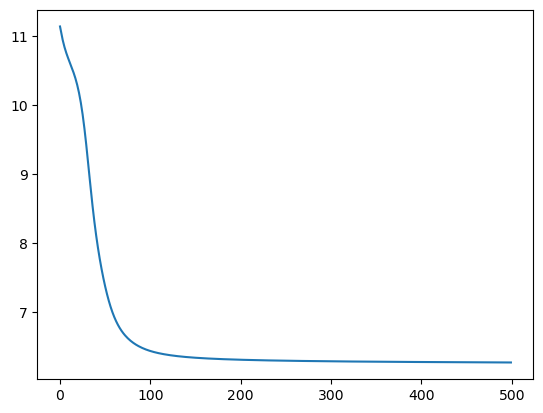

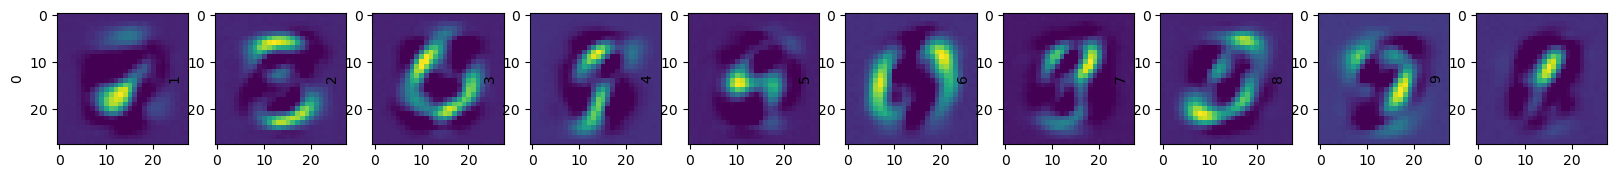

In [14]:
def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

def NMF(X, k, ret_cost = False):
    # choosing the number of dimensions (r, called here k) on which to project
    # we take the first 6000 images
    n_datapoints = np.shape(X)[0]

    # reshaping and taking a slice of the data
    X = normalize_nmf(X[:n_datapoints,:])

    # k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
    H = np.random.rand(k, X.shape[1])

    # N x k components matrix, usually interpreted as the coefficients, N is the number of data
    W = np.random.rand(X.shape[0], k)

    # set the number of iterations
    n_iters = 500
    pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

    # empty list 
    cost_values = []
    # loop over the n iterations
    if ret_cost:
        for i in range(n_iters):
            # compute the update on H
            H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count))
            # compute the update on W
            W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count))
            # compute the cost and append to list
            X_pred = np.matmul(W, H)
            cost_values.append(loss(X, X_pred))
        return W, H, cost_values
    
    else:
        for i in range(n_iters):
            # compute the update on H
            H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count))
            # compute the update on W
            W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count))
        return W, H


W, H, cost_values = NMF(X_noisy, 10, True)
plt.plot(np.arange(500), cost_values)

# plot a heatmap of the 10 components
nrow = 1; ncol = 10;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(20,4))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(H[i, :].reshape([28,28]))
    ax.set_ylabel(str(i))


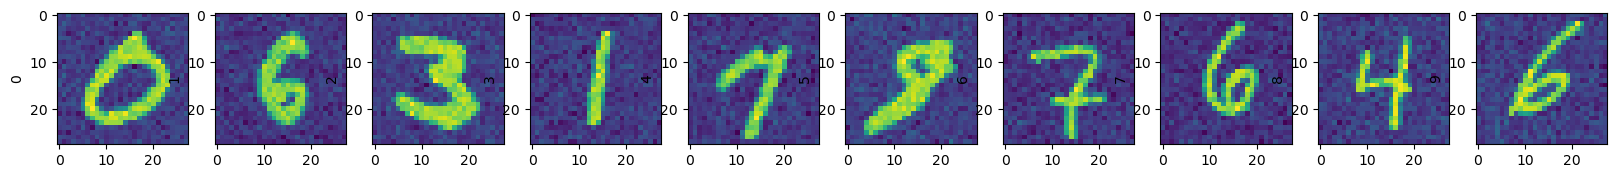

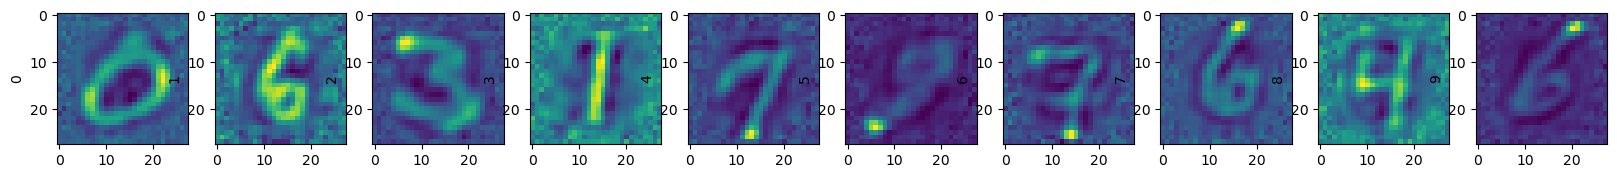

In [21]:
MNIST_test_noisy = pd.read_csv("MNIST_test_noisy.txt", sep= " ", header=None)
X_test_noisy = np.array(MNIST_test_noisy)
X_pred_PCA = reconstruct_PCA(X_noisy, X_test_noisy, 100)

# plot a heatmap of the 10 components
nrow = 1; ncol = 10;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(20,4))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(X_test_noisy[i, :].reshape([28,28]))
    ax.set_ylabel(str(i))

# plot a heatmap of the 10 components
nrow = 1; ncol = 10;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(20,4))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(X_pred_PCA[i, :].reshape([28,28]))
    ax.set_ylabel(str(i))


In [315]:
def KL_divergence(p, q):
    """
    Compute the KL divergence between two distributions.
    """
    return np.sum(p * ((np.log1p(p)) - (np.log1p(q)))) / len(p)

def cost_KL(X, W, H):
    """
    Compute the KL divergence between the original data and the reconstructed data.
    """
    # Compute the reconstruction
    X_recon = W.dot(H)

    # Compute the KL divergence
    KL = KL_divergence(X, X_recon)

    return KL

### 1.2.2

In [316]:
def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X)) ## <-- SOLUTION
    return X_norm

def NMF(X, m = 10, n_iter = 500):
        
        # Normalize the data
        X = normalize_nmf(X)
        
        # Initialize W and H
        W = np.random.rand(X.shape[0], m)
        H = np.random.rand(m, X.shape[1])
        
        # Initialize the cost history
        cost_history = []
        
        # Iterate until convergence
        for i in tqdm(range(n_iter), desc='Iterations: ', colour='green'):
            
            # Update H
            H = H * np.dot(W.T, X) / np.dot(np.dot(W.T, W), H)
            # Update W
            W = W * np.dot(X, H.T) / np.dot(np.dot(W, H), H.T)
            
            # Update the cost history
            cost_history.append(cost_KL(X,W,H))
            
        return W, H, cost_history

In [317]:
X_noise = pd.read_csv('data/MNIST_train_noisy.txt', sep=' ', header=None).values

X_test = pd.read_csv('data/MNIST_test.csv').drop('label', axis=1).values

X_test_noise = pd.read_csv('data/MNIST_test_noisy.txt', sep=' ', header=None).values

W, H, costs = NMF(X_noise, m=10, n_iter=300)

Iterations: 100%|██████████| 300/300 [01:15<00:00,  3.95it/s]


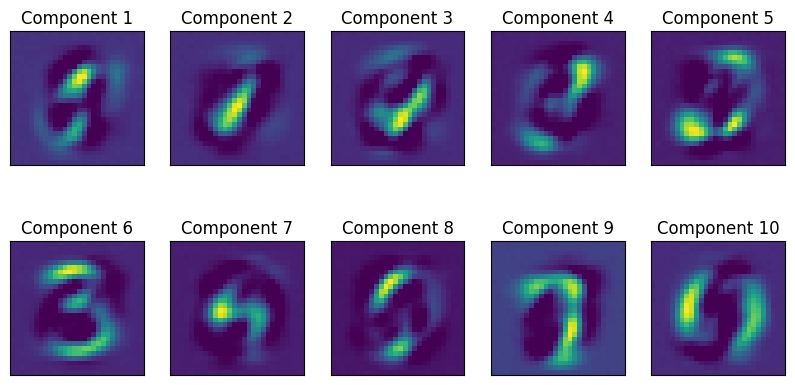

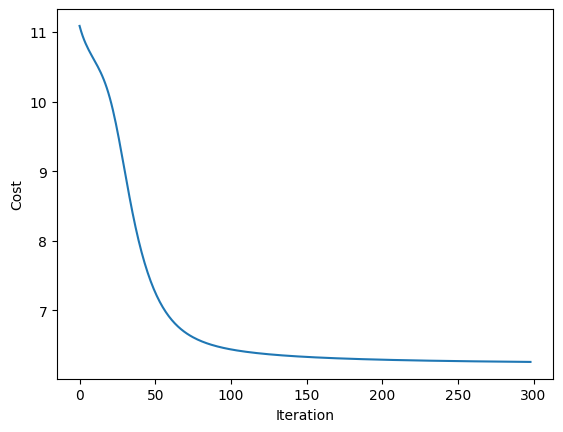

In [318]:
# Plot the first 10 component
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(H[i,:].reshape(28, 28))
    ax.set_title('Component {}'.format(i+1))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# Plot the cost
plt.plot(costs[1:])
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

### 1.2.3

In [319]:
def PCA_reconstruction(X_train, X_noise, n_components):
    """
    Compute the reconstruction of the data using PCA.
    """
    # Compute the PCA
    X_proj, cumvar_exp, eig_vecs = PCA(X_train, n_components)

    X_noise_proj = X_noise.dot(eig_vecs)
    X_recon = X_noise_proj.dot(eig_vecs.T)
    
    X_recon = (X_recon + np.mean(X_noise)) * np.std(X_noise) * X_recon

    return X_recon

In [320]:
def NMF_reconstruction(X_train,X_noise, n_components):
    """
    Compute the reconstruction of the data using NMF.
    """
    # Compute the NMF
    W, H, costs = NMF(X_train, m=n_components, n_iter=300)

    W = np.random.rand(X_noise.shape[0], n_components)

    for i in tqdm(range(300), desc='Iterations: ', colour='green'):
        W = W * np.dot(X_noise, H.T) / np.dot(np.dot(W, H), H.T)
    
    X_recon = W.dot(H)
    X_recon = X_recon * (np.max(X_noise) - np.min(X_noise)) + np.min(X_noise)

    return X_recon

In [321]:
# Denoise the test data
X_test_denoised_PCA = PCA_reconstruction(X_noise, X_test_noise, 100)
X_test_denoised_NMF = NMF_reconstruction(X_noise, X_test_noise, 100)

Iterations: 100%|██████████| 300/300 [00:02<00:00, 120.13it/s]


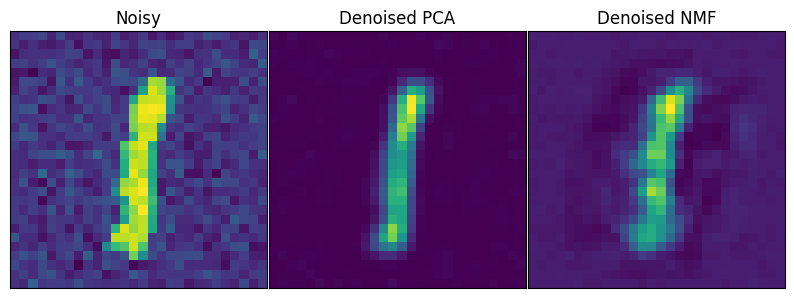

In [322]:
# Choose a random test image
j = np.random.randint(0, X_test_noise.shape[0])

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_noise[j,:].reshape(28, 28)) # Plot the noisy data
    ax.set_title('Noisy')
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes.flat[1:]):
    ax.imshow(X_test_denoised_PCA[j,:].reshape(28, 28)) # Plot the denoised data
    ax.set_title('Denoised PCA')
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes.flat[2:]):
    ax.imshow(X_test_denoised_NMF[j,:].reshape(28, 28)) # Plot the denoised data
    ax.set_title('Denoised NMF')
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.01, hspace=0)
plt.show()


### 1.2.4

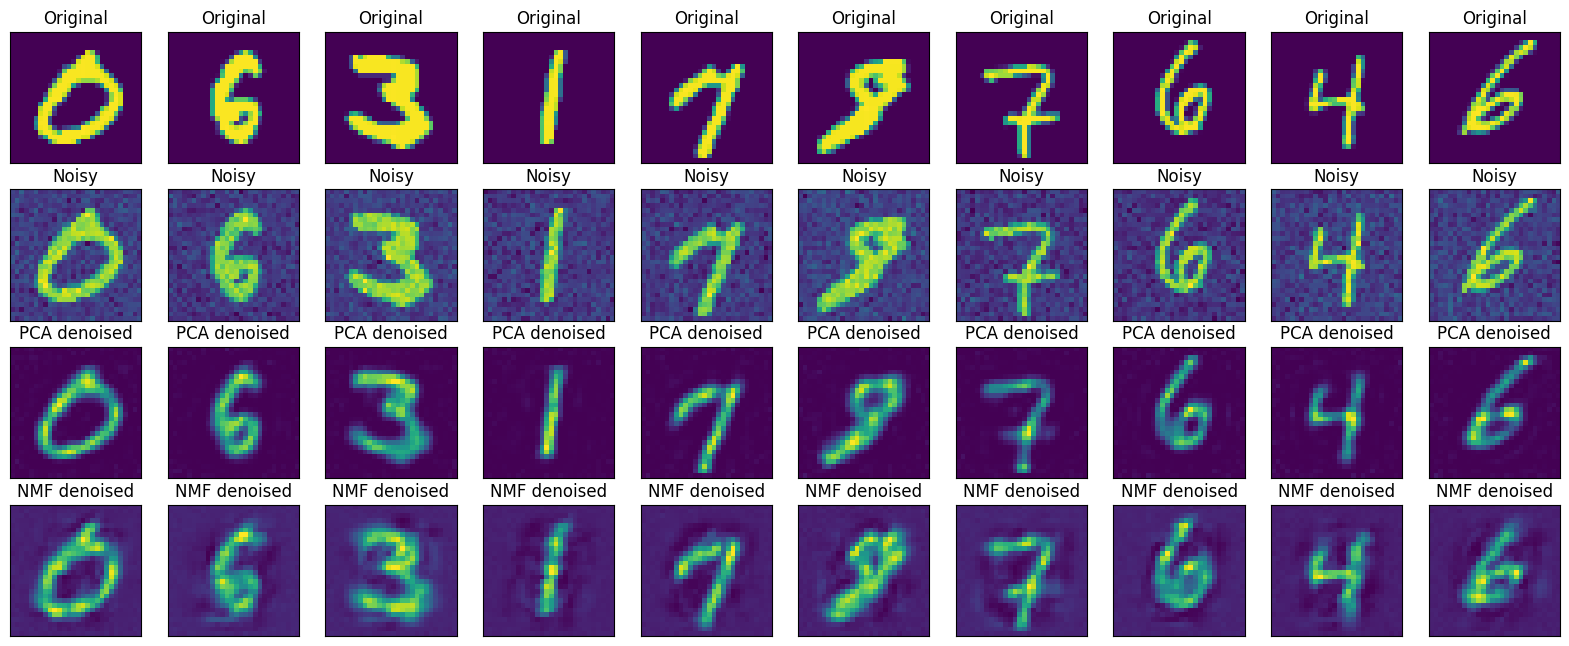

In [323]:
# Plot first 10 images of X_test, X_test_noise, X_noise and X_test_denoised_PCA
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
for i, ax in enumerate(axes.flat[:10]):
    ax.imshow(X_test[i,:].reshape(28, 28))
    ax.set_title('Original')
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes.flat[10:20]):
    ax.imshow(X_test_noise[i,:].reshape(28, 28))
    ax.set_title('Noisy')
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes.flat[20:30]):
    ax.imshow(X_test_denoised_PCA[i,:].reshape(28, 28))
    ax.set_title('PCA denoised')
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes.flat[30:]):
    ax.imshow(X_test_denoised_NMF[i,:].reshape(28, 28))
    ax.set_title('NMF denoised')
    ax.set_xticks([])
    ax.set_yticks([])
# Change the spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()

In [324]:
# Compute the reconstruction errors

def MSE(X, X_reconstructed):
    return np.mean((X - X_reconstructed)**2)

# Compute the reconstruction error

print("Original data")
print('MSE for PCA: {}'.format(MSE(standardise(X_test), standardise(X_test_denoised_PCA))))
print('MSE for NMF: {}'.format(MSE(standardise(X_test), standardise(X_test_denoised_NMF))))
print()
print("Noisy data")
print('MSE for PCA: {}'.format(MSE(standardise(X_test_noise), standardise(X_test_denoised_PCA))))
print('MSE for NMF: {}'.format(MSE(standardise(X_test_noise), standardise(X_test_denoised_NMF))))

Original data
MSE for PCA: 0.5193661020408734
MSE for NMF: 0.8299045746337983

Noisy data
MSE for PCA: 0.8324674338173237
MSE for NMF: 1.09850743476389


In [325]:

# Plot the MSE for different number of components
mse_original = []
mse_noise = []

for i in tqdm(range(5, 405, 5), desc='Components: ', colour='green'):
    X_PCA = PCA_reconstruction(X_noise, X_test_noise, i)
    # X_NMF = NMF_reconstruction(X_noise, X_test_noise, i)

    mse_original.append(MSE(standardise(X_test), standardise(X_PCA)))
    mse_noise.append(MSE(standardise(X_test_noise), standardise(X_PCA)))


Components: 100%|██████████| 80/80 [01:11<00:00,  1.12it/s]


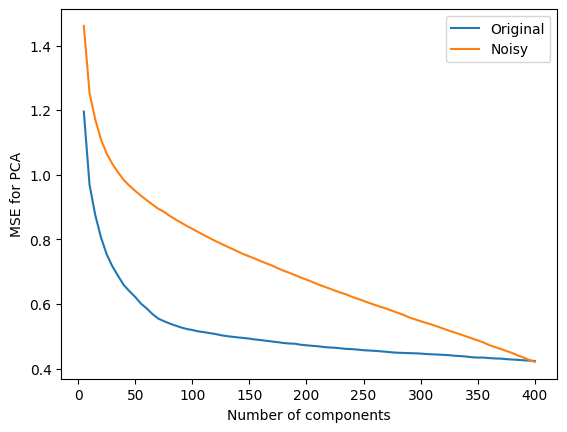

In [326]:
# Plot the MSE for different number of components
plt.plot(range(5, 405, 5), mse_original, label='Original')
plt.plot(range(5, 405, 5), mse_noise, label='Noisy')
plt.xlabel('Number of components')
plt.ylabel('MSE for PCA')
plt.legend()
plt.show()

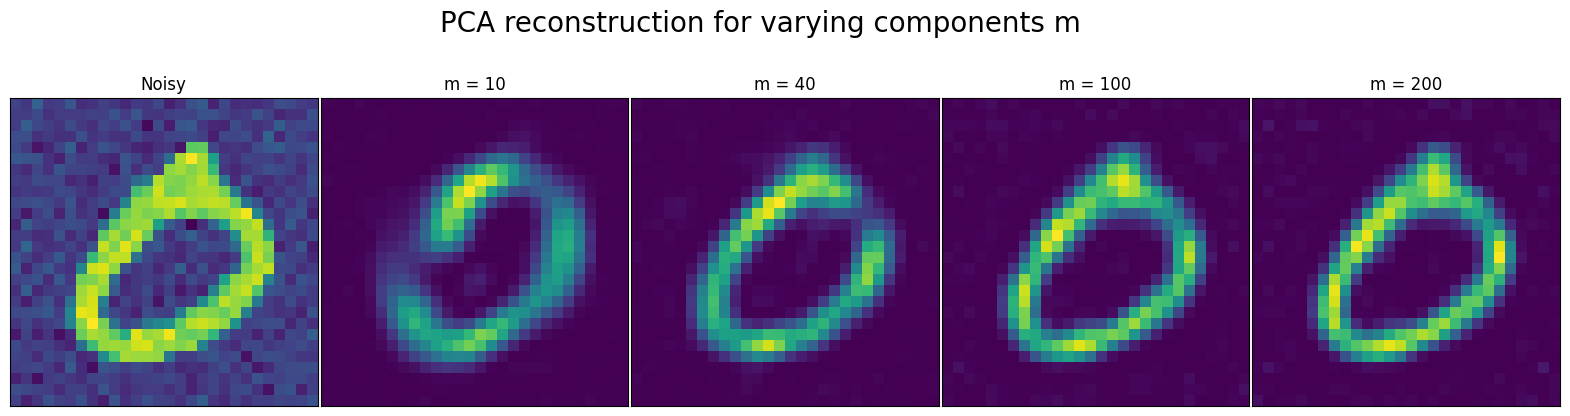

In [327]:
# Plot the first element and reconstruction for m = 10, 40, 100, 200 components
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_noise[0,:].reshape(28, 28)) # Plot the noisy data
    ax.set_title('Noisy')
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes.flat[1:]):
    ax.imshow(PCA_reconstruction(X_noise, X_test_noise, [10,40,100,200][i])[0,:].reshape(28, 28)) # Plot the denoised data
    ax.set_title('m = {}'.format([10,40,100,200][i]))
    ax.set_xticks([])
    ax.set_yticks([])
# Change the spacing between subplots
plt.subplots_adjust(wspace=0.01, hspace=0)
plt.suptitle('PCA reconstruction for varying components m', fontsize=20)
plt.show()


### 1.3.1

In [328]:
def multivariate_normal_pdf(X, mu, sigma):
    n_samples, n_features = X.shape
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    N = np.sqrt((2 * np.pi) ** n_features * sigma_det)
    fac = np.einsum('ij, ij -> i', np.dot(X - mu, sigma_inv), (X - mu))
    return np.exp(-fac / 2) / N

In [329]:
class GaussianMixture:

    def __init__(self, k, n_iter=100, tol=1e-3):
        self.k = k
        self.n_iter = n_iter
        self.tol = tol

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize the parameters
        self.pi = np.ones(self.k) / self.k
        self.mu = np.random.rand(self.k, n_features)
        self.sigma = np.array([np.eye(n_features)] * self.k)

        # Initialize the responsibilities
        r = np.zeros((n_samples, self.k))

        for i in tqdm(range(self.n_iter), desc='Iterations: ', colour='green'):
            # Expectation step
            for j in range(self.k):
                r[:, j] = self.pi[j] * multivariate_normal_pdf(X, self.mu[j, :], self.sigma[j, :, :])

            r = r / np.sum(r, axis=1, keepdims=True)

            # Maximization step
            self.pi = np.mean(r, axis=0)
            self.mu = np.dot(r.T, X) / np.sum(r, axis=0, keepdims=True).T
            for j in range(self.k):
                diff = X - self.mu[j, :]
                self.sigma[j, :, :] = np.dot(r[:, j] * diff.T, diff) / np.sum(r[:, j])

            # Check for convergence
            if np.sum(np.abs(self.pi - np.mean(r, axis=0))) < self.tol:
                break

    def predict(self, X):
        n_samples, n_features = X.shape
        r = np.zeros((n_samples, self.k))
        for j in range(self.k):
            r[:, j] = self.pi[j] * multivariate_normal_pdf(X, self.mu[j, :], self.sigma[j, :, :])
        r = r / np.sum(r, axis=1, keepdims=True)
        return np.argmax(r, axis=1)
    
    def score(self, X):
        n_samples, n_features = X.shape
        r = np.zeros((n_samples, self.k))
        for j in range(self.k):
            r[:, j] = self.pi[j] * multivariate_normal_pdf(X, self.mu[j, :], self.sigma[j, :, :])
        r = r / np.sum(r, axis=1, keepdims=True)
        return np.sum(np.log(np.sum(r, axis=1, keepdims=True)))

In [330]:
df_train = pd.read_csv('data/MNIST_train.csv')

X = np.array(df_train.drop('label', axis=1))[:1000]
Y = np.array(df_train['label'])[:1000]

In [331]:
# Compute the first 5 principal components
X_proj, cum_var_exp, eig_vecs = PCA(X, 5)

gmm = GaussianMixture(10, n_iter=10**6, tol=1e-8)
gmm.fit(X_proj)

Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]/var/folders/6v/4ltv3nvd5dngbl4qj4710hs80000gn/T/ipykernel_13258/3810427941.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  r[:, j] = self.pi[j] * multivariate_normal_pdf(X, self.mu[j, :], self.sigma[j, :, :])
/var/folders/6v/4ltv3nvd5dngbl4qj4710hs80000gn/T/ipykernel_13258/3810427941.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  self.sigma[j, :, :] = np.dot(r[:, j] * diff.T, diff) / np.sum(r[:, j])
Iterations:   0%|          | 0/1000000 [00:00<?, ?it/s]


/var/folders/6v/4ltv3nvd5dngbl4qj4710hs80000gn/T/ipykernel_13258/3810427941.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  r[:, j] = self.pi[j] * multivariate_normal_pdf(X, self.mu[j, :], self.sigma[j, :, :])
/Users/arnav/opt/anaconda3/envs/tf/lib/python3.9/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


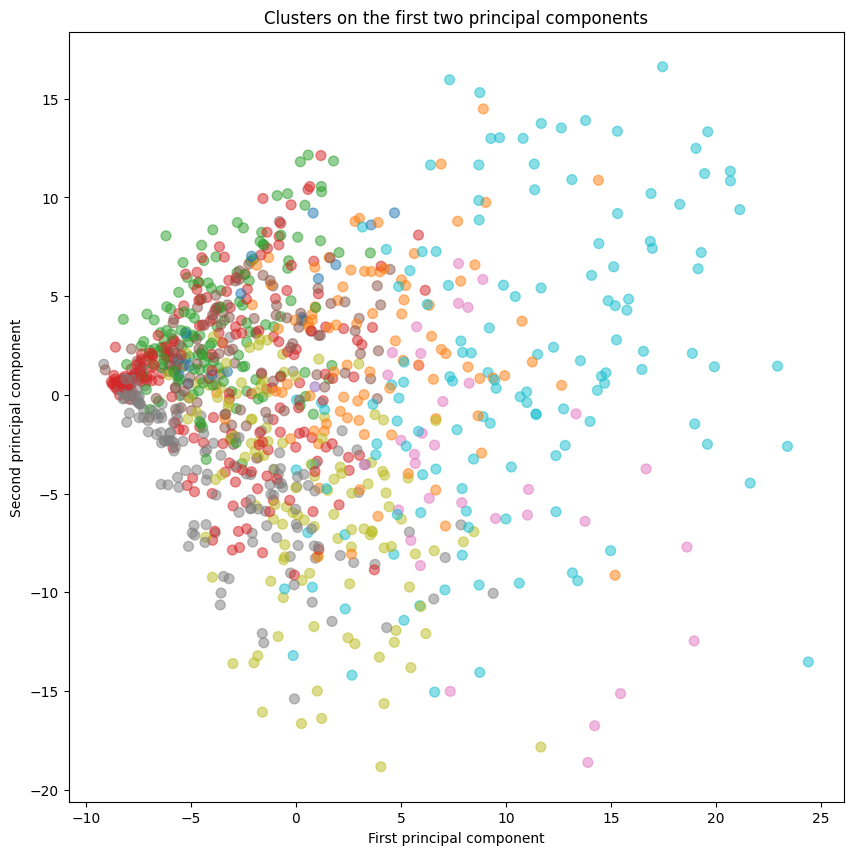

In [332]:
# Visualise the clusters on the first two principal components

plt.figure(figsize=(10, 10))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=gmm.predict(X_proj), cmap='tab10', alpha=0.5, s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Clusters on the first two principal components')
plt.show()

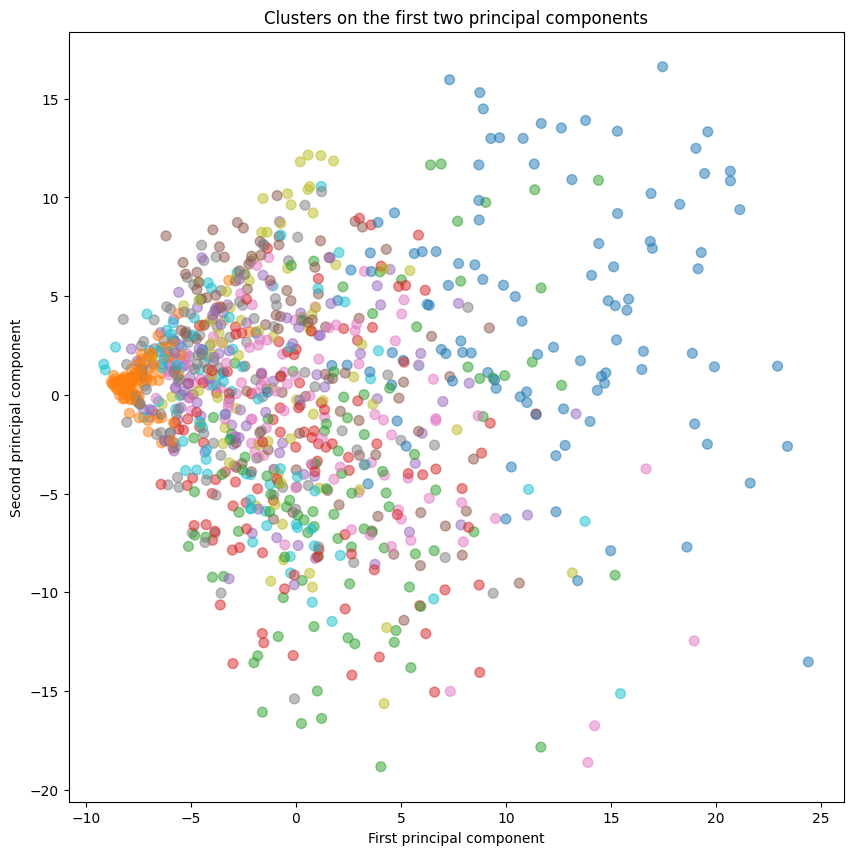

In [333]:
# Use class labels to visualise the clusters on the first two principal components

plt.figure(figsize=(10, 10))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=Y, cmap='tab10', alpha=0.5, s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Clusters on the first two principal components')
plt.show()

In [334]:
# Find the most frequent cluster label for each class
cluster_labels = np.zeros(10)
for i in range(10):
    cluster_labels[i] = np.argmax(np.bincount(gmm.predict(X_proj)[Y == i])) # Find the most frequent cluster label for each class

print('Cluster labels: {}'.format(cluster_labels))

Cluster labels: [9. 3. 8. 3. 5. 3. 8. 2. 3. 2.]


/var/folders/6v/4ltv3nvd5dngbl4qj4710hs80000gn/T/ipykernel_13258/3810427941.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  r[:, j] = self.pi[j] * multivariate_normal_pdf(X, self.mu[j, :], self.sigma[j, :, :])


In [335]:
# TO FINISH THE REST OF THIS OFF LATER

# 2.1

# Clustering goes here

In [358]:
df = pd.read_csv('data/gene_expression_data.csv')

gene_Y = np.array(df['Type'])
gene_X = np.array(df.drop('Type', axis=1))

# k-means clustering
def Kmeans(X, k = 5, max_iter = 30):
    n_samples, n_features = X.shape 

    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        if [x for x in X_labels if x[-1]==i]: centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]
        else: continue

    new_labels = np.zeros(len(X))

    # k-means algorithm
    for i in range(max_iter):
        # print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            # print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)   
            # print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)    ## <-- EDIT THIS LINE

    return labels, centroids


In [363]:
labels, centroids = Kmeans(gene_X, k=5)


In [362]:
def Cal_hara(X, centroids, labels):
    """Calculates the Calinski-Harabasz index"""
    n, m = X.shape
    k = len(centroids)
    # between-cluster sum of squares
    BCSS = 0
    for i in range(k):
        BCSS += np.sum((centroids[i] - np.mean(X, axis=0))**2)
    BCSS *= n
    # within-cluster sum of squares
    WCSS = 0
    for i in range(k):
        WCSS += np.sum((X[labels==i] - centroids[i])**2)
    # Calinski-Harabasz index
    CH = BCSS / (k - 1) / (WCSS / (n - k))
    return CH

def optimal_k(X):
    """Finds the optimal number of clusters"""
    CH = []
    for k in range(2, 10):
        #Repeat and average 5 times 
        CH_val = 0
        for _ in range(5):
            labels, centroids = Kmeans(X, k)
            CH_val += (Cal_hara(gene_X, centroids, labels))
        CH.append(np.mean(CH_val))
    return CH, CH.index(min(CH)) + 2

optimal_k(gene_X)

([4896.419636555343,
  11855.356607772253,
  14520.971847408591,
  13329.054035778832,
  14075.070733670793,
  14650.008101136205,
  14285.285911581896,
  16083.800856997545],
 2)

In [365]:
def Cal_hara(X, centroids, labels):
    """Calculates the Calinski-Harabasz index"""
    n, m = X.shape
    k = len(centroids)
    # between-cluster sum of squares
    BCSS = 0
    for i in range(k):
        BCSS += np.sum((centroids[i] - np.mean(X, axis=0))**2)
    BCSS *= n
    # within-cluster sum of squares
    WCSS = 0
    for i in range(k):
        WCSS += np.sum((X[labels==i] - centroids[i])**2)
    # Calinski-Harabasz index
    CH = BCSS / (k - 1) / (WCSS / (n - k))
    return CH

def optimal_k(X):
    """Finds the optimal number of clusters"""
    CH = []
    for k in range(2, 10):
        #Repeat and average 5 times 
        CH_val = 0
        for _ in range(5):
            labels, centroids = Kmeans(X, k)
            CH_val += (Cal_hara(gene_X, centroids, labels))
        CH.append(CH_val/5)
    return CH, CH.index(min(CH)) + 2

optimal_k(gene_X)

([1242.3541681570807,
  1985.6993937969644,
  2904.1943694817187,
  2806.481372374767,
  2855.17612788769,
  3344.5827316723617,
  3044.6376153374667,
  3239.583282162787],
 2)

### 2.1.2

In [367]:
def homogeneity_score(labels_true, labels_pred):
    """Homogeneity metric of a cluster labeling given a ground truth.
    A clustering result satisfies homogeneity if all of its clusters contain
    only data points which are members of a single class.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        Ground truth class labels to be used as a reference
    labels_pred : array, shape = [n_samples]
        Cluster labels to evaluate
    Returns
    -------
    homogeneity : float
       0.0 <= homogeneity <= 1.0
       The score is bounded by 0.0 and 1.0. 1.0 stands for perfectly
       homogeneous labeling
    """

    n_samples = len(labels_true)
    n_clusters = len(np.unique(labels_pred))
    n_classes = len(np.unique(labels_true))
    #print(n_samples, n_clusters, n_classes)
    h_score = 0
    for i in range(n_clusters):
        for j in range(n_classes):
            n_ij = np.sum((labels_true == j) & (labels_pred == i))
            n_i = np.sum(labels_pred == i)
            n_j = np.sum(labels_true == j)
            if n_ij == 0: continue
            h_score += (n_ij/n_samples) * np.log((n_samples*n_ij)/(n_i*n_j))
    return h_score 

# 2.2

### 2.2.1

### 2.2.2

In [338]:
# Compute the degree centralities of each gene
degree = corr.sum(axis=1)

# Sort the genes by degree centrality
degree.sort_values(ascending=False)

# Print the index of the 5 most central genes and their degree centralities
degree.sort_values(ascending=False).index[:5]
degree[degree.sort_values(ascending=False).index[:5]]

Gene 17    19.738399
Gene 41    19.049456
Gene 16    18.640284
Gene 81    18.531790
Gene 90    18.267052
dtype: float64

### 2.2.3

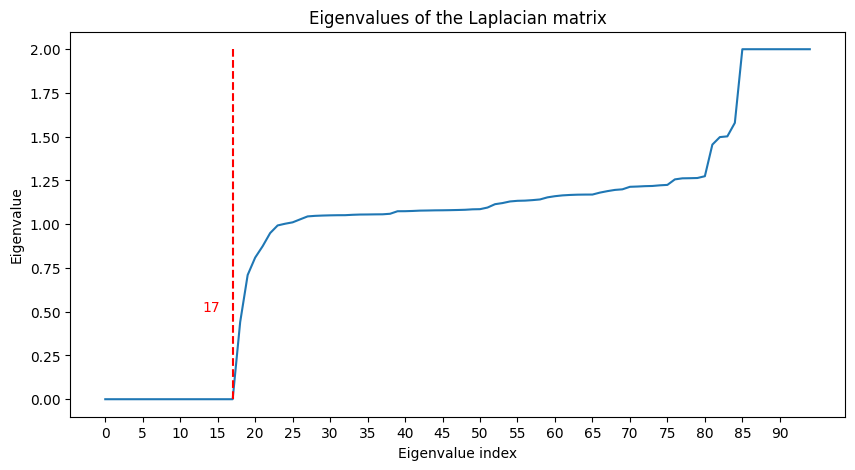

There are  18 zero eigenvalues


In [339]:
# Compute the symmetric normalized Laplacian matrix
D = np.diag(1/np.sqrt(degree))
L = np.eye(len(degree)) - D @ corr @ D

# Compute the eigenvectors and eigenvalues of the Laplacian matrix
eigvals, eigvecs = np.linalg.eigh(L)

# Round the small eigenvalues to zero
eigvals = np.round(eigvals, 8)

# Find the first non-zero eigenvalue
last_zero = np.where(eigvals > 0)[0][0] - 1

# Plot the eigenvalues, marking where they first become non-zero
plt.figure(figsize=(10,5))
plt.plot(eigvals)
plt.plot([last_zero, last_zero], [0, 2], 'r--')
# Set label for the red line
plt.text(last_zero - 4 , 0.5, str(last_zero), color='red')
# Set ticks for each 5 indices
plt.xticks(np.arange(0, len(eigvals), 5))
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Laplacian matrix')
plt.show()

print("There are ", last_zero+1, "zero eigenvalues")

In [340]:
# Create U a 95 x r matrix of the first r eigenvectors of L
U = eigvecs[:, :last_zero+1]

# Create T by normalising rows of U to 1
T = U / np.linalg.norm(U, axis=1)[:, np.newaxis]

In [342]:
k_values = np.arange(2,40)

# Using the elbow method to find the optimal number of clusters
wcd = []
for k in tqdm(k_values):
    labels, centroids = Kmeans(T, k)
    # Compute the within-cluster distance
    score = 0
    for l in range(k):
        cluster = T[labels == l]
        dist = 0
        for i in range(len(cluster)):
            for j in range(len(cluster)):
                dist += np.sum((cluster[i] - cluster[j])**2) # Euclidean distance
        if len(cluster):
            score += dist / (2*len(cluster))
    wcd.append(score)

100%|██████████| 38/38 [00:00<00:00, 55.10it/s]


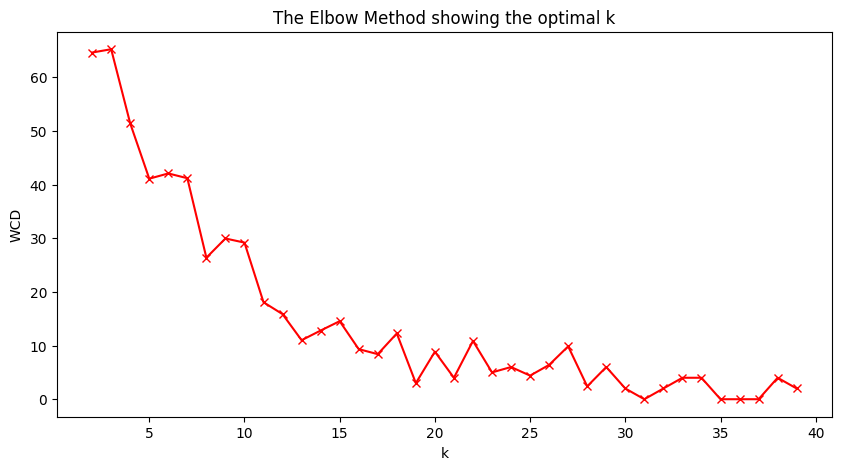

In [343]:

plt.figure(figsize=(10,5))
plt.plot(k_values, wcd, 'rx-')
plt.xlabel('k')
plt.ylabel('WCD')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [344]:
# Find the largest cluster calculated above
labels, centroids = Kmeans(T, 18)

largest_cluster = np.argmax(np.bincount(labels))
print("The largest cluster is cluster", largest_cluster)
print("The largest cluster has" , np.bincount(labels)[largest_cluster], "elements")

The largest cluster is cluster 7
The largest cluster has 16 elements


In [345]:
# Print index of genes in the largest cluster
largest_cluster_genes = list(df.index[np.where(labels == largest_cluster)[0]])

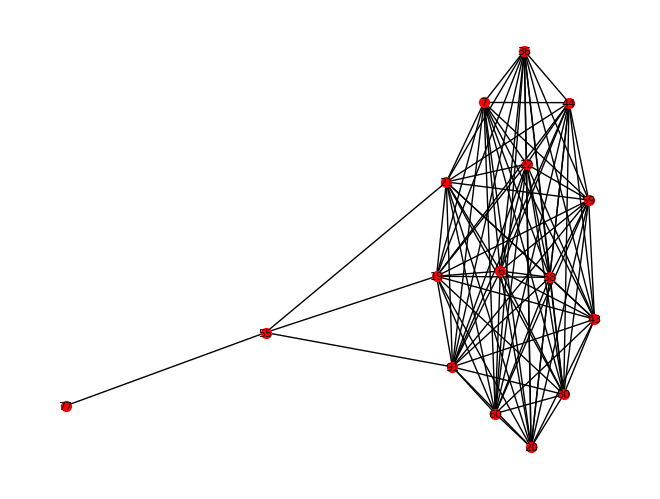

In [346]:
# Draw a graph of the largest cluster
G = nx.Graph()
for i in range(len(labels)):
    if labels[i] == largest_cluster:
        for j in range(len(labels)):
            if labels[j] == largest_cluster and corr.iloc[i, j] != 0:
                G.add_edge(i, j)

nx.draw(G, with_labels=True, node_size=50, node_color='red', font_size=8)
plt.show()

In [347]:
"""Perform spectral partitioning on the largest cluster"""

# Compute the laplacian matrix of the largest cluster
corr_largest_cluster = corr.iloc[largest_cluster_genes, largest_cluster_genes]
np.fill_diagonal(corr_largest_cluster.values, 0)
degree_largest_cluster = corr_largest_cluster.sum(axis=1)
D = np.diag(1/np.sqrt(degree_largest_cluster))
L = np.eye(len(degree_largest_cluster)) - D @ corr_largest_cluster @ D

# Compute the eigenvectors and eigenvalues of the Laplacian matrix
eigvals, eigvecs = np.linalg.eigh(L)
eigvals

array([2.30020267e-16, 4.40674341e-01, 1.05146914e+00, 1.05968737e+00,
       1.07419326e+00, 1.07444423e+00, 1.07577484e+00, 1.07772569e+00,
       1.07840825e+00, 1.07930189e+00, 1.07966193e+00, 1.08036281e+00,
       1.08130455e+00, 1.08252594e+00, 1.08512021e+00, 1.57934555e+00])

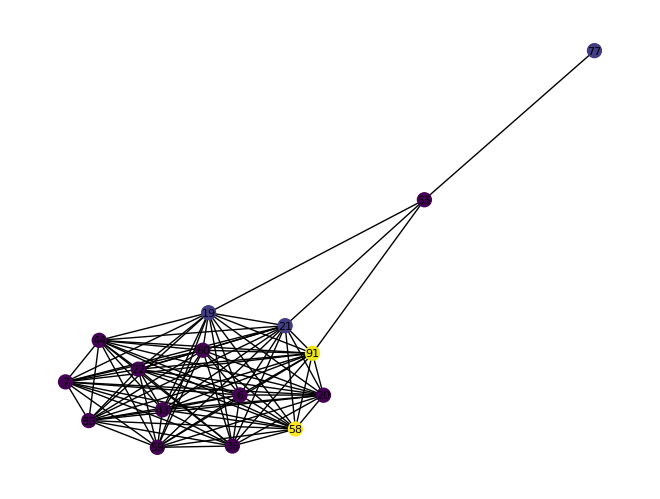

In [348]:
nx.draw(G, with_labels=True, node_size=100, node_color=eigvecs[:,1], font_size=8)

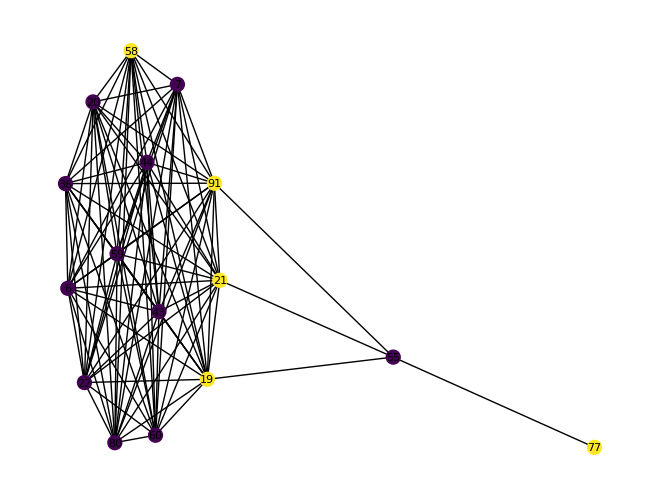

In [349]:
spectral_partition = eigvecs[:,1]
spectral_partition[spectral_partition > 0] = 1
spectral_partition[spectral_partition < 0] = 0

nx.draw(G, with_labels=True, node_size=100, node_color=spectral_partition, font_size=8)

In [350]:
# Compute the degree centrality of each node
degree_centrality = nx.degree_centrality(G)

# Print the top 5 nodes with the highest degree centrality and their centrality score
sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]


[(19, 0.9333333333333333),
 (21, 0.9333333333333333),
 (91, 0.9333333333333333),
 (6, 0.8666666666666667),
 (7, 0.8666666666666667)]

In [351]:
degree[degree.sort_values(ascending=False).index[:5]]

Gene 17    19.738399
Gene 41    19.049456
Gene 16    18.640284
Gene 81    18.531790
Gene 90    18.267052
dtype: float64